# Geo2Vec with Optimal Transport assignment 

In [1]:
import sys
sys.path.append("../../healthcare-breast-recommender/")

In [32]:
import os
import pickle

import torch
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

from src.dataset.toy import ToyDataset, CIRCLE_RADIUS, save_dataset, load_dataset
from src.ml.model import ModelOT
from src.ml.train import prepare_input_data, train_model, assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [30]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [31]:
%autoreload 2

## 1. Dataset generation

### 1.1 Load the toy dataset.

Source code is in `src.dataset.toy.ToyDataset`.

Run this cell to generate a new toy dataset.

In [14]:
n_centers = 3
n_pois = 3
n_users = 1000
distance_weight = 0.5

toy = ToyDataset(
    n_centers=n_centers,
    n_pois=n_pois,
    n_users=n_users,
    distance_weight=distance_weight,
    noise=0
)

### 1.2 Test the toy dataset

In [15]:
# test capacities
assert type(toy.pois_capacities) == np.ndarray
assert toy.pois_capacities.shape == (1, n_pois)
assert np.min(toy.pois_capacities) > 0
assert np.sum(toy.pois_capacities) > n_users

# test users
assert type(toy.users_features) == np.ndarray
assert toy.users_features.shape == (n_users, 2)  # 2D feature space

# test distance
assert type(toy.D) == np.ndarray
assert toy.D.shape == (n_users, n_pois)
assert np.min(toy.D) >= 0  # Distances must be positive

# test assignment
assert type(toy.assigned_poi_for_user) == np.ndarray
assert toy.assigned_poi_for_user.shape == (n_users,)
assert all(np.unique(toy.assigned_poi_for_user, return_counts=True)[1]  # no capacity excess
           <= toy.pois_capacities[0])

### 1.3 Plot the dataset

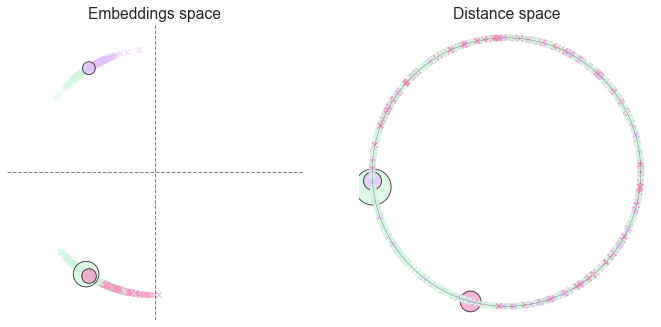

In [24]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
plt.tight_layout()

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    pois_features=torch.from_numpy(toy.pois_features),
    pois_capacities=toy.pois_capacities,
    y_pred=toy.assigned_poi_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.pois_x, toy.pois_y))),
    CIRCLE_RADIUS,
    toy.assigned_poi_for_user,
    toy.pois_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

plt.show()

In [17]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "toy_dataset.png"), dpi=300)

In [33]:
save_dataset(toy, "../data/toy.pkl")

In [35]:
# load_dataset("../data/toy.pkl")

## 2. Model training

### 2.1 Prepare input data

In [18]:
users_tensor, pois_tensor, D_tensor, y_true = prepare_input_data(toy)

### 2.2 Test input data

In [19]:
assert users_tensor.shape == torch.Size([n_users,])
assert pois_tensor.shape == torch.Size([n_users, n_pois])
assert D_tensor.shape == torch.Size([n_users, n_pois])
assert y_true.shape == torch.Size([n_users])

assert isinstance(users_tensor, torch.LongTensor)
assert isinstance(pois_tensor, torch.LongTensor)
assert isinstance(D_tensor, torch.FloatTensor)
assert isinstance(y_true, torch.LongTensor)

### 2.3 Train the model

Uncomment next line to reload the model if changing the source code in `src.ml.model.ModelOT`

In [20]:
# %autoreload 2

In [38]:
#################
# Declare model #
#################

model = ModelOT(
    capacities=toy.pois_capacities,
    n_users=toy.n_users,
    epsilon=0.05,
    alpha=0.5,
    n_iter=20,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)
model.train()

optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.NLLLoss()

n_epochs = 400

#########
# Train #
#########

losses = []
scores = []

for epoch in range(n_epochs):
    train_epoch_loss = 0
    optimizer.zero_grad()

    # model out
    r_ij = model(users_tensor, pois_tensor, D_tensor)
    e_usage = r_ij.sum(axis=0)

    # predictions
    # y_pred = torch.argmax(r_ij, axis=1)
    # y_pred = torch.distributions.Categorical(torch.exp(r_ij)).sample()
    y_pred = assign_with_lap(r_ij, toy.pois_capacities)
    
    # torch.sum(model.affinity_matrix*r_ij) / users_tensor.shape[0]

    # loss function
    nll_loss = criterion(torch.log(r_ij), y_true)
    loss = nll_loss
    train_epoch_loss += loss.item()
    loss.backward()

    # optimizer
    optimizer.step()

    # training loss
    losses.append([loss.item()])

    # training scores
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
    scores.append([acc, f1])
    
########################
# Store training stats #
########################

losses_df = pd.DataFrame(
    dict(
        epoch=["{0}".format(i) for i in np.arange(1, len(losses)+1)],
        loss=[l[0] for l in losses]
    )
)

scores_df = pd.DataFrame(
    dict(
        epoch=["{0}".format(i) for i in np.arange(1, len(losses)+1)],
        acc=[s[0] for s in scores],
        f1=[s[1] for s in scores]
    )
)

capacities_df = pd.DataFrame(
    dict(
        center_id=["POI {0}".format(i)
                   for i in np.arange(1, toy.pois_capacities.shape[1]+1)],
        capacities=toy.pois_capacities.reshape(-1),
        expected_usage=e_usage.data.numpy(),
        actual_usage=torch.nn.functional.one_hot(
            y_pred,
            num_classes=toy.pois_capacities.shape[1]
        ).sum(axis=0).data.numpy()
    )
)

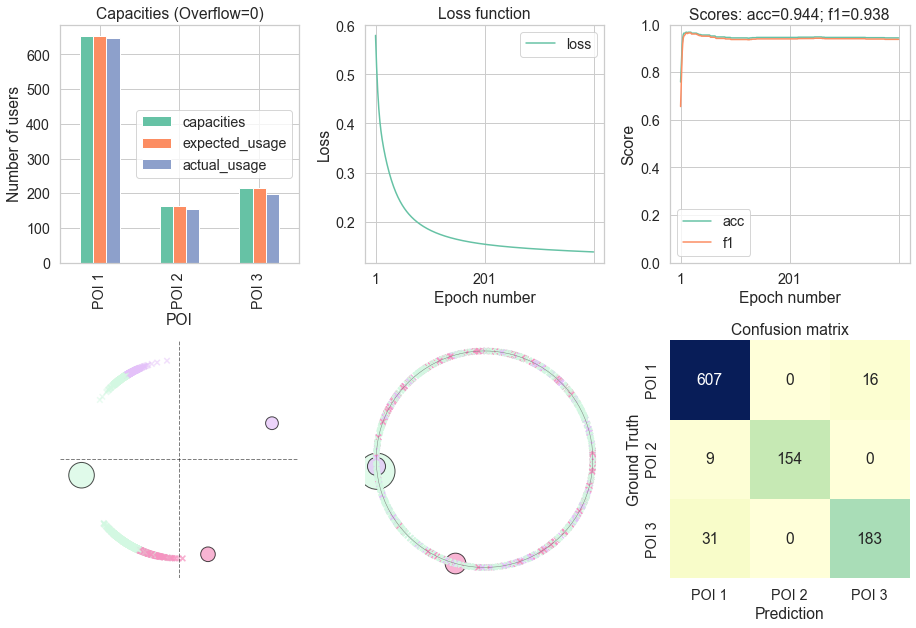

In [39]:
#######################
# Plot training stats #
#######################

fig, axs = plt.subplots(figsize=(13, 9), nrows=2, ncols=3)

# Capacities barplot
viz.plot_capacities(
    capacities_df,
    axs[0][0]
)

axs[0][0].legend(loc="center right")

# Loss function per epoch
viz.plot_losses(
    losses_df,
    axs[0][1]
)

# Accuracy and F1 scores per epoch
viz.plot_scores(
    scores_df,
    axs[0][2]
)

# Learned pois embeddings and assigned users
viz.plot_embeddings(
    users_features=model.user_embeddings.weight,
    pois_features=model.poi_embeddings.weight,
    pois_capacities=toy.pois_capacities,
    y_pred=y_pred,
    ax=axs[1][0]
)

# Distance circle and assigned users
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.pois_x, toy.pois_y))),
    CIRCLE_RADIUS,
    y_pred,
    toy.pois_capacities,
    axs[1][1]
)

# Confusion matrix as heatmap
viz.plot_heatmap(
    y_true,
    y_pred,
    toy.pois_capacities.shape[1],
    axs[1][2]
)

plt.tight_layout()
plt.show()

In [23]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "training_results.png"), dpi=300)

### 2.4 Trying various parameters

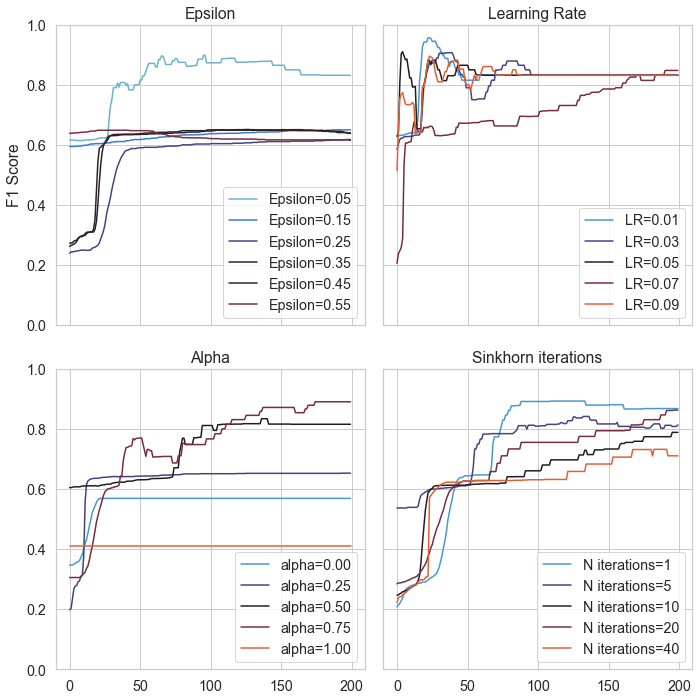

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        figsize=(10, 10), 
                        sharex=True, sharey=True)

axs[0][0].set_ylim(0, 1)
axs[0][0].set_xlabel("Epoch")
axs[0][0].set_ylabel("F1 Score")

pal = "icefire"

###########
# Epsilon #
###########

for i, epsilon in enumerate(np.arange(0.05, 0.6, 0.1)):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=epsilon, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("Epsilon={0:.2f}".format(epsilon)).plot(
        ax=axs[0][0],
        color=sns.color_palette(pal, n_colors=8)[i]
    )
    axs[0][0].legend(loc="lower right")
    axs[0][0].set_title("Epsilon")
    
#################
# Learning rate #
#################

for i, lr in enumerate(np.arange(0.01, 0.1, 0.02)):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=lr, 
        epsilon=0.05, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("LR={0:.2f}".format(lr)).plot(
        ax=axs[0][1],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[0][1].legend(loc="lower right")
    axs[0][1].set_title("Learning Rate")
    
#########
# Alpha #
#########

for i, alpha in enumerate(np.arange(0.0, 1.25, 0.25)):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=0.05, 
        n_iter=10,
        alpha=alpha, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("alpha={0:.2f}".format(alpha)).plot(
        ax=axs[1][0],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[1][0].legend(loc="lower right")
    axs[1][0].set_title("Alpha")
    
#######################
# Sinkhorn iterations #
#######################

for i, n_iter in enumerate([1, 5, 10, 20, 40]):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=0.05, 
        n_iter=n_iter,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("N iterations={0}".format(n_iter)).plot(
        ax=axs[1][1],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[1][1].legend(loc="lower right")
    axs[1][1].set_title("Sinkhorn iterations")
    
plt.tight_layout()
plt.show()

In [17]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_params.png"), dpi=300)

### 2.7 Test repeatability

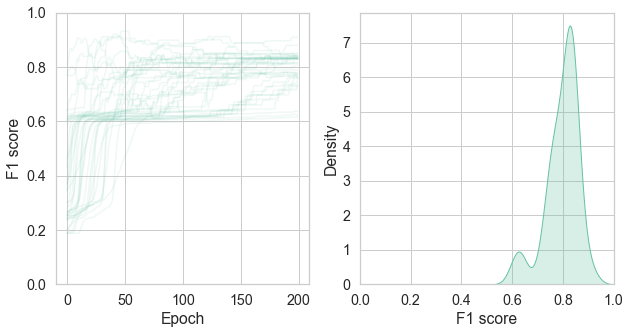

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

scores = []

for _ in range(40):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=0.05, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores.append(scores_df_tmp["f1"].iloc[-1])
    
    # Plot 1: lines with F1 per epoch
    scores_df_tmp["f1"].plot(ax=axs[0], 
                             alpha=.1, 
                             color=sns.color_palette()[0])
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("F1 score")
    
# Plot 2: F1 scores distribution
sns.kdeplot(scores,
            ax=axs[1],
            fill=True)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel("F1 score")
axs[1].set_ylabel("Density")

plt.show()

In [20]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_repeatability.png"), dpi=300)

## 3. Overflow analysis

In [21]:
values = []

for epsilon in np.arange(0.05, 1, 0.1):
    y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=epsilon, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,
        assign="argmax",
        users_features=toy.users_features,
        train_user_embeddings=False
    )

    diff = (capacities_df_tmp["actual_usage"] - capacities_df_tmp["capacities"]).values
    overflow = np.where(diff > 0, diff, 0).sum()
    
    values.append({"epsilon": epsilon, "overflow": overflow})

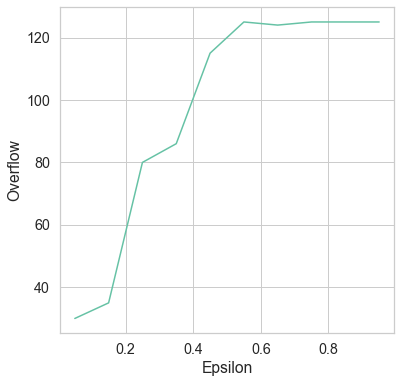

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.lineplot(
    data=pd.DataFrame(values),
    x="epsilon",
    y="overflow",
    ax=ax
)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Overflow")

plt.show()

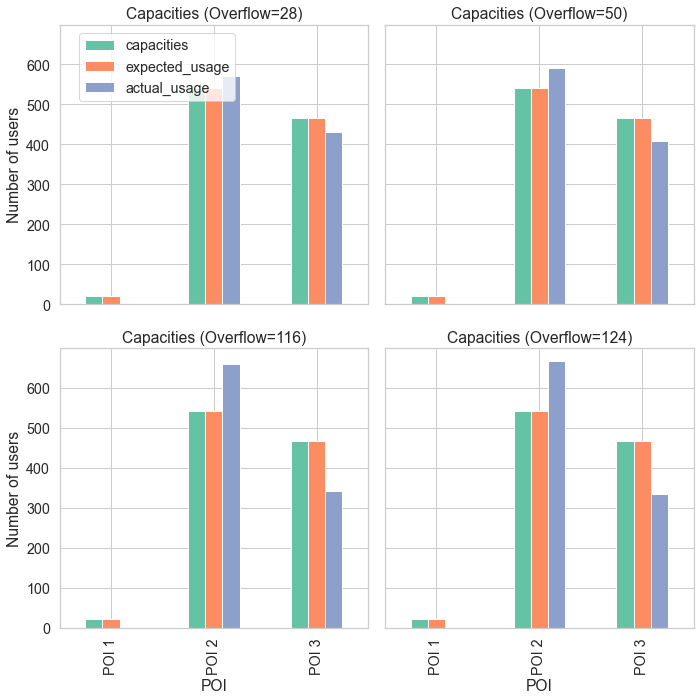

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        figsize=(10, 10), 
                        sharex=True, sharey=True)

for i, epsilon in enumerate([0.05, 0.1, 0.5, 1]):
    y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=epsilon, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200, 
        assign="argmax",
        users_features=toy.users_features,
        train_user_embeddings=False
    )

    diff = (capacities_df_tmp["actual_usage"] - capacities_df_tmp["capacities"]).values
    overflow = np.where(diff > 0, diff, 0).sum()

    viz.plot_capacities(capacities_df_tmp, axs[i//2][i%2])
    axs[i//2][i%2].get_legend().remove()

# legend
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.35, .95))
    
plt.tight_layout()
plt.show()

In [24]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_epsilon_overflow.png"), dpi=300)

In [33]:
f1_tmp = []

for epsilon in np.arange(0.05, 1, 0.1):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor, 
        pois_tensor, 
        D_tensor, 
        y_true, 
        toy.pois_capacities, 
        lr=0.01,
        epsilon=epsilon, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=400,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    f1_tmp.append(dict(epsilon=epsilon, f1=scores_df_tmp["f1"].iloc[-1]))

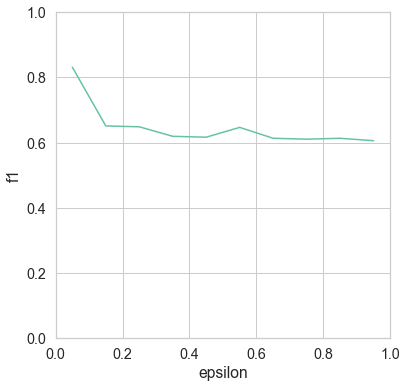

In [34]:
fig = plt.figure(figsize=(6, 6))

ax = sns.lineplot(data=pd.DataFrame(f1_tmp), x="epsilon", y="f1")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()

In [35]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_f1_epsilon.png"), dpi=300)

## 5. Dataset influence (noise & distance weight)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharex=True, sharey=True)

scores = []

for i, noise in enumerate(np.arange(0, 1.1, .1)):
    users_tensor_tmp, pois_tensor_tmp, D_tensor_tmp, y_true_tmp = prepare_input_data(toy)
    
    # apply noise to y_true without drawing a new dataset
    y_true_tmp_noised = toy.add_random_permutations(int(noise*toy.n_users))
    y_true_tmp = torch.from_numpy(y_true_tmp_noised)
    
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        users_tensor_tmp, 
        pois_tensor_tmp, 
        D_tensor_tmp, 
        y_true_tmp, 
        toy.pois_capacities, 
        lr=0.01, 
        epsilon=0.05, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=400,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores.append(scores_df_tmp["f1"].iloc[-1])
    
    # Plot 1: lines with F1 per epoch
    scores_df_tmp["f1"].rename("Noise={0:.1f}".format(noise)).plot(
        ax=axs[0],
        color=sns.color_palette("icefire", n_colors=11)[i]
    )
    
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("F1 score")
    axs[0].legend(loc="lower right", ncol=1)

for i, alpha in enumerate(np.arange(0, 1.1, 0.1)):
    toy_tmp = ToyDataset(
        n_centers=n_centers,
        n_pois=n_pois,
        n_users=n_users,
        distance_weight=alpha,
        noise=0
    )
    
    users_tensor_tmp, pois_tensor_tmp, D_tensor_tmp, y_true_tmp = prepare_input_data(toy_tmp)
    
    y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
        users_tensor_tmp, 
        pois_tensor_tmp, 
        D_tensor_tmp, 
        y_true_tmp, 
        toy_tmp.pois_capacities, 
        lr=0.01, 
        epsilon=0.1, 
        n_iter=10,
        alpha=alpha, 
        n_epochs=400,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("Alpha={0:.1f}".format(alpha)).plot(
        ax=axs[1],
        color=sns.color_palette("icefire", n_colors=11)[i]
    )
    
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("F1 score")
    axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_dataset.png"), dpi=300)